# Import Libraries and Clean Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, balanced_accuracy_score, f1_score, recall_score, precision_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [5]:
subreddits = pd.read_csv('./data/posts_combined_clean.csv')

In [6]:
subreddits.shape

(7976, 10)

# Naive Bayes Model

### X, y, train test split

In [7]:
X = subreddits['title']
y = subreddits['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Baseline Model

In [9]:
y.value_counts(normalize=True)

science       0.572091
technology    0.427909
Name: subreddit, dtype: float64

In [10]:
# the target in the dataset for posts was split approximately 57% for r/science.
# This will be the baseline model - if we guessed r/science each time we would 
# be correct 57% of the time

### Modeling

In [11]:
bayes_pipe = make_pipeline(
    CountVectorizer(stop_words='english', max_features=500),
    StandardScaler(with_mean=False),
    MultinomialNB(),
)

In [12]:
bayes_params = {
    'countvectorizer__max_features': [100, 500, 1000]
}

In [13]:
bayes_grid = GridSearchCV(bayes_pipe, bayes_params)

In [14]:
bayes_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_features': [100, 500, 1000]})

In [15]:
bayes_grid.best_params_

{'countvectorizer__max_features': 1000}

In [16]:
cross_val_score(bayes_pipe, X_test, y_test, cv=10)

array([0.825     , 0.83      , 0.79      , 0.805     , 0.84422111,
       0.82914573, 0.73869347, 0.81909548, 0.78894472, 0.84422111])

### Bayes Model Scores

In [17]:
preds_bayes = bayes_grid.predict(X_test)

In [18]:
precision_bayes = precision_score(y_test, preds_bayes, pos_label='science')
recall_bayes = recall_score(y_test, preds_bayes, pos_label='science')
f1_bayes = 2 * (precision_bayes * recall_bayes) / (precision_bayes + recall_bayes)

In [19]:
print(f'The accuracy training score is    {bayes_grid.score(X_train, y_train)}')
print(f'The accuracy testing score is     {bayes_grid.score(X_test, y_test)}')
print(f'The bac score is                  {balanced_accuracy_score(y_test, bayes_grid.predict(X_test))}')
print(f'The f1_score score is             {f1_bayes}')
print(f'The precision is                  {precision_bayes}')
print(f'The recall is                     {recall_bayes}')

The accuracy training score is    0.8839852892009361
The accuracy testing score is     0.8445336008024072
The bac score is                  0.8409999182739458
The f1_score score is             0.8627103631532329
The precision is                  0.8558875219683656
The recall is                     0.8696428571428572


- This model performed slightly worse than the the Logistic regression model. It had a lower accuracy score on the test set and the balanced accuracy and f-1 score was slightly lower.

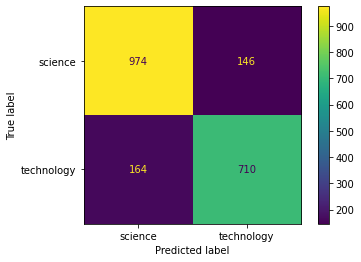

In [20]:
plot_confusion_matrix(bayes_grid, X_test, y_test);

- There are less false positives and false negatives than in the logistic regression model

### Feature Importance

In [23]:
bayes_pipe = make_pipeline(
    CountVectorizer(stop_words='english', max_features=1000),
    StandardScaler(with_mean=False),
    MultinomialNB(),
)
bayes_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [24]:
coefs = bayes_pipe.named_steps['multinomialnb'].coef_
coef_df = pd.DataFrame({'coefs': coefs[0]}, index = bayes_pipe.named_steps['countvectorizer'].get_feature_names())
coef_df.nlargest(10, 'coefs')

c:\programdata\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


,coefs
app,-4.965116
apple,-4.980787
trump,-5.092372
2021,-5.123997
free,-5.126309
amazon,-5.134596
facebook,-5.165895
google,-5.191097
tech,-5.202293
twitter,-5.219766


- Most words that have a high weight in the model are large tech companies as well as some words that relate to politics.

### TfidfVectorizer

In [31]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train)
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names())
tfidf_df.head()

,000,10,100,11,12,13,15,18,19,20,...,women,work,workers,working,world,xiaomi,year,years,young,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.415513,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [37]:
pipe_tfidf = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=500),
    StandardScaler(with_mean=False),
    MultinomialNB(),
)

In [38]:
params = {
    'tfidfvectorizer__max_features': [100, 200, 500, 800, 1000],
    'tfidfvectorizer__ngram_range': [(1, 2), (2, 2)],
}
grid_tfidf = GridSearchCV(pipe_tfidf, params)
grid_tfidf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=500,
                                                        stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'tfidfvectorizer__max_features': [100, 200, 500, 800,
                                                           1000],
                         'tfidfvectorizer__ngram_range': [(1, 2), (2, 2)]})

In [39]:
grid_tfidf.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

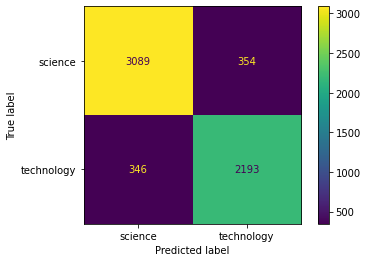

In [40]:
plot_confusion_matrix(grid_tfidf, X_train, y_train);

- False positives: 354 were science, labeled as technology
- False negatives: 346 technology, labled as science

### Tfidf Score

In [41]:
preds_tfidf = grid_tfidf.best_estimator_.predict(X_test)

In [42]:
precision_tfidf = precision_score(y_test, preds_tfidf, pos_label='science')
recall_tfidf = recall_score(y_test, preds_tfidf, pos_label='science')
f1_tfidf = 2 * (precision_tfidf * recall_tfidf) / (precision_tfidf + recall_tfidf)

In [43]:
print(f'The accuracy training score is    {grid_tfidf.score(X_train, y_train)}')
print(f'The accuracy testing score is     {grid_tfidf.score(X_test, y_test)}')
print(f'The bac score is                  {balanced_accuracy_score(y_test, grid_tfidf.predict(X_test))}')
print(f'The f1_score score is             {f1_tfidf}')
print(f'The precision is                  {precision_tfidf}')
print(f'The recall is                     {recall_tfidf}')

The accuracy training score is    0.8829822801738549
The accuracy testing score is     0.8405215646940822
The bac score is                  0.8369258744687806
The f1_score score is             0.8591674047829938
The precision is                  0.8523725834797891
The recall is                     0.8660714285714286


- The model did slightly worse when Tfidf was added to the MultinomialNB model 